# Photometry

## Files selection

We first list all the FITS files in the repository and retrieve their headers. Form these headers, we get the images dates and type of exposure (bias, dark, flat or light). In our case, this information is stored in the `IMAGETYP` keyword

In [1]:
from astropy.io import fits
from dateutil import parser
from glob import glob
from collections import defaultdict

files = glob("/Users/lgarcia/code/pysnack10-prose/light_data/*.fits")
files_meta = defaultdict(dict)
observations = defaultdict(lambda: defaultdict(int))

for file in files:
    header = fits.getheader(file)
    file_date = parser.parse(header["DATE-OBS"])
    files_meta[file]["date"] = file_date
    files_meta[file]["type"] = header["IMAGETYP"]
    observations[file_date.date()][files_meta[file]["type"]] += 1

Notice how we also created an `observations` dictionary to store the number of file per date and type. Let's print its content

In [2]:
for date, obs in observations.items():
    print(date, f"\n{'-'*len(str(date))}")
    for obs_type, count in obs.items():
        print(f"{obs_type}: {count}")

2015-09-17 
----------
LIGHT: 163
FLAT: 30
DARK: 52
BIAS: 11


We then select the light images and sort them by date

In [3]:
lights = list(filter(lambda f: files_meta[f]["type"] == "LIGHT", files))
lights = sorted(lights, key=lambda f: files_meta[f]["date"])
observation_date = files_meta[list(lights)[0]]["date"].date()

In the following cell, we select the calibration files that match our main observation's date.

In [4]:
def filter_files(files, file_type):
    return list(
        filter(
            lambda f: files_meta[f]["type"] == file_type
            and files_meta[f]["date"].date() == observation_date,
            files,
        )
    )


biases = filter_files(files, "BIAS")
darks = filter_files(files, "DARK")
flats = filter_files(files, "FLAT")

From these files, we then create a master bias, dark and flat that will be used to calibrate our light frames.

In [5]:
from eloy import calibration

bias = calibration.master_bias(files=biases)
dark = calibration.master_dark(files=darks, bias=bias)
flat = calibration.master_flat(files=flats, bias=bias, dark=dark)

## Reference image

The first thing we will do to process our images is to select a reference image, for example

In [6]:
# reference
reference_file = lights[len(lights) // 2]

This reference frame will be used to align other images and to detect the stars present in the field of view, stars from which we will extract the photometry in all remaining images.

In order to detect these reference stars, we will start by calibrating our reference image. 

```{note}
As the calibration and detection sequence (plus some other image processing tasks like trimming and PSF modeling) also need to be ran for the other images, let's create a function we can reuse later.
```

In [7]:
import numpy as np
from eloy import psf, detection, utils

trim = 50
n_stars_align = 12


def calibration_sequence(file):
    # getting data
    data = fits.getdata(file)
    header = fits.getheader(file)
    exposure = header["EXPTIME"]

    # calibration
    calibrated_data = calibration.calibrate(data, exposure, dark, flat, bias)
    # trimming
    calibrated_data = calibrated_data[trim:-trim, trim:-trim]
    # detection
    regions = detection.stars_detection(calibrated_data)
    # stars coords and cutouts
    region_coords = np.array([(r.centroid[1], r.centroid[0]) for r in regions])
    cutouts = utils.cutout(calibrated_data, region_coords, (50, 50))

    # epsf modeling
    cutouts_normalized = cutouts / np.nanmax(cutouts, (1, 2))[:, None, None]
    epsf = np.nanmedian(cutouts_normalized, 0)
    psf_params = psf.fit_gaussian(epsf)
    fwhm = psf.gaussian_sigma_to_fwhm * np.mean(
        [psf_params["sigma_x"], psf_params["sigma_y"]]
    )

    del (
        cutouts_normalized,
        data,
        regions,
        cutouts,
        epsf,
        header,
    )

    return calibrated_data, region_coords, fwhm

Let's apply this function on the reference image and plot the detected stars.

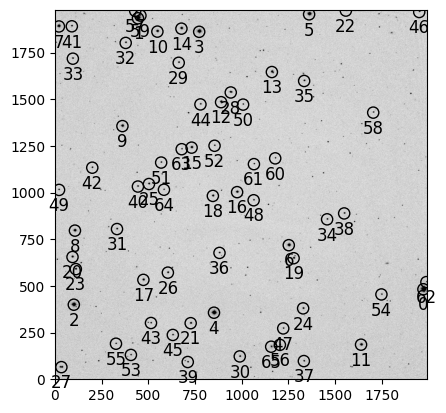

In [8]:
import matplotlib.pyplot as plt
from eloy import alignment, viz

ref_data, ref_coords, ref_fwhm = calibration_sequence(reference_file)
ref_reference = alignment.twirl_reference(ref_coords[0:n_stars_align])

plt.imshow(viz.z_scale(ref_data), cmap="Greys", origin="lower")
viz.plot_marks(*ref_coords.T, color="k", label=True, ms=30)

## Photometry

We will now extract the photometry of the reference stars in the remaining images. In the photometry sequence we, perform aperture photometry on stars positions aligned with the reference stars positions. We also evaluate the local background around each star using an annulus centered on the its position.

In [9]:
from tqdm.autonotebook import tqdm
from skimage.transform import AffineTransform
from eloy import centroid, photometry

n_stars = 20
cutout_shape = (21, 21)
relative_apertures_radii = np.linspace(0.1, 5, 40)

data = defaultdict(list)

for file in tqdm(lights):
    calibrated_data, coords, fwhm = calibration_sequence(file)

    # alignment
    R = alignment.rotation_matrix(coords[0:n_stars_align], ref_coords, ref_reference)
    transform = AffineTransform(R).inverse
    aligned_coords = transform(ref_coords)[0:n_stars]
    dx, dy = np.median(ref_coords[0:n_stars] - aligned_coords, 0)

    # centroiding
    centroid_coords = centroid.photutils_centroid(
        calibrated_data, aligned_coords, centroid_fun=centroid.centroid_quadratic
    )
    # aperture photometry
    apertures_radii = relative_apertures_radii * fwhm
    flux = photometry.aperture_photometry(
        calibrated_data, centroid_coords, apertures_radii
    )
    # annulus background correction
    annulus_radii = np.max(apertures_radii), 8 * fwhm
    aperture_area = np.pi * apertures_radii**2
    bkg = photometry.annulus_sigma_clip_median(
        calibrated_data, centroid_coords, *annulus_radii
    )
    bkg = bkg[:, None] * aperture_area[None, :]

    # getting data
    header = fits.open(file)[0].header
    data["bkg"].append(bkg)
    data["fluxes"].append(flux)
    data["fwhm"].append(fwhm)
    data["time"].append(header["JD"])
    data["dx"].append(dx)
    data["dy"].append(dy)


for k, v in data.items():
    data[k] = np.array(v)

/var/folders/q0/m16jxqmd1zj3rhbhwkklywk40000gq/T/ipykernel_5229/4277059863.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/163 [00:00<?, ?it/s]

At the end of this sequence, we retrieved and stored some useful measurements from our images.

## Differential light curve

In [11]:
from eloy import flux

target = 16
fluxes = (data["fluxes"] - data["bkg"]).T
diffs, weights = flux.auto_diff(fluxes, target)
best_aperture = flux.optimal_flux(diffs[:, target])
diff = diffs[best_aperture, target]

(0.98, 1.02)

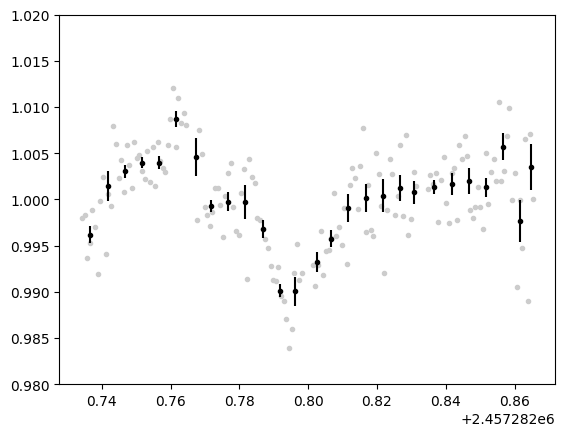

In [18]:
idxs = utils.index_binning(data["time"], 0.005)
binned_time = [data["time"][i].mean() for i in idxs]
binned_diff = [diff[i].mean() for i in idxs]
binned_error = [diff[i].std() / np.sqrt(len(i)) for i in idxs]

plt.plot(data["time"], diffs[best_aperture, target, :], ".", c="0.8")
plt.errorbar(binned_time, binned_diff, yerr=binned_error, fmt=".", c="k")
plt.ylim(0.98, 1.02)